In [1]:
import numpy as np
import sympy, scipy, cmath
from sympy import *
#from sympy import symbols
#from sympy.solvers.solveset import nonlinsolve
from scipy import sparse as sp
#from scipy import linalg as ln
from scipy import optimize as opt
from scipy.sparse import  coo_matrix as cmm
from matplotlib import pyplot as pp

In [8]:
#Parameters
#global kx,mu, m, t, alR, B, kF, a, al, delta, phi, delL, delR, nu0, tL, tR, NJ, eye2, s1, s2, s3, tP, tM, t3

kx=0.

mu=1.8
m=.5
t=1
alR=0.
def mut(kx):
    return mu-2*t-kx**2/(2*m)-alR**2*m/2
B=0.5
kF=np.sqrt(2*m*mu)

a=1/np.sqrt(2*m*t)
al=alR/a

delta=0.3
phi=np.pi
def delL(phi):
    return delta*cmath.exp(1j*phi/2)
def delR(phi):
    return delta*cmath.exp(-1j*phi/2)
nu0=m/(2*np.pi)
def xiE(En):
    return kF/(m*cmath.sqrt(delta**2-En**2))

tL=2
tR=tL
GammaL=np.pi*nu0*tL**2 #=m*tL**2/2
GammaR=np.pi*nu0*tR**2 #=m*tR**2/2

NJ=1

ET=np.pi/2*kF/m/(NJ*a)

#matrix tools
eye2=np.eye(2)
eye4=np.eye(4)
s1=[[0,1],[1,0]]
s2=[[0,-1j],[1j,0]]
s3=[[1,0],[0,-1]]
tP=np.kron([[0,1],[0,0]],eye2)
tM=np.kron([[0,0],[1,0]],eye2)
t3=np.kron(s3,eye2)

In [9]:
#Junction
def HJ0(kx):
    return -mut(kx)*t3+alR*kx*np.kron(s3,s2)+B*np.kron(eye2,s1)
Hy=-t*t3+1j*al/2*np.kron(s3,s1)


def HJ(kx):
    start=cmm(HJ0(kx))
    HJs=start
    for n in range(2,NJ+1):
        OT=cmm(np.zeros([len(HJs.toarray())-4,4]))
        BT=sp.vstack([OT,cmm(Hy)])
        CT=sp.hstack([OT.transpose(),cmm(Hy.conj().T),start])
        HJs=sp.hstack([HJs,BT])
        HJs=sp.vstack([HJs,CT])
    return HJs

def gJm1(En,kx):
    return En*np.eye(4*NJ)-HJ(kx).toarray()

#Superconductors
# xiE-> infty to avoid more symbolic:
#def fL(kx):
#    return 1/(kF*a)*(np.log(1-np.exp(1j*a*(kF+kx)))+np.log(1-np.exp(1j*a*(kF-kx))))-1j

def fL(En,kx):
    return 1/(kF*a)*(cmath.log(1-cmath.exp(-a/xiE(En)+1j*a*(kF+kx)))+cmath.log(1-cmath.exp(-a/xiE(En)+1j*a*(kF-kx))))-1j

def gSC1m1(En,kx,phi):
    return 1/(np.pi*nu0*abs(fL(En,kx))**2)*((En*eye4 - delL(phi)*tP - np.conj(delL(phi))*tM)*\
                                                 fL(En,kx).imag/cmath.sqrt(delta**2 - En**2) - fL(En,kx).real*t3)

def gSC2m1(En,kx,phi):
    return 1/(np.pi*nu0*abs(fL(En,kx))**2)*((En*eye4 - delR(phi)*tP - np.conj(delR(phi))*tM)*\
                                                 fL(En,kx).imag/cmath.sqrt(delta**2 - En**2) - fL(En,kx).real*t3)

#SC/J coupling
rowindex=np.array([1,2,3,4,4*NJ+1,4*NJ+2,4*NJ+3,4*NJ+4])-1
colindex=np.array([5,6,7,8,4*(NJ+1)+1,4*(NJ+1)+2,4*(NJ+1)+3,4*(NJ+1)+4])-1
hoppings=[tL,tL,-tL,-tL,tR,tR,-tR,-tR]
mHt1=cmm((hoppings,(rowindex,colindex)),shape=(4*(NJ+2),4*(NJ+2)))
mHt=mHt1+mHt1.transpose()

#total inverse GF
def Gtotm1(En,kx,phi):
    return scipy.linalg.block_diag(gSC1m1(En,kx,phi),gJm1(En,kx),gSC2m1(En,kx,phi))+mHt.toarray()

In [10]:
L=30 #phi decimation
phiarray=np.arange(L+1)*2*np.pi/L#/5+np.pi*4/5
EJdisp=np.zeros((4*(NJ+2),L+1)) #2*NJ when single site =1 & 4*NJ when mutliple sites
for j in range(L+1):
    print(j)
    ekx=[]
    phi=phiarray[j]
    def fdet(En):
        return np.linalg.det(Gtotm1(En,kx,phi))/(mu**(8*NJ)) #here change between isolated junction and total system
    #jtmm=[-5+0.1*opq for opq in range(51)]
    x0roots=np.ndarray.tolist(np.linspace(-delta,delta,np.int(2*delta/0.1)))
    #x0roots.extend(jtmm)
    for i in range(len(x0roots)):
        x0=x0roots[i]
        solekx=opt.fsolve(fdet,np.asarray(x0))
        if abs(fdet(solekx))>10**(-11) or abs(solekx)>=delta:
            solekx=[]
        solekx=np.ndarray.tolist(np.around(solekx,7))
        ekx.extend(solekx)
    ekx=list(set(ekx))
    print(ekx)
    if len(ekx)<4*(NJ+2):
        zerocompletion=[delta]*(4*(NJ+2)-len(ekx))
        ekx.extend(zerocompletion)
    elif len(ekx)>4*(NJ+2):
        print("Too many roots.")
        break
    for p in range(4*(NJ+2)):
        EJdisp[p,j]=np.asarray(ekx[p])
    
    if j==np.ceil(1.1*L/2):
        break

0
[]
1
[]
2


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in divide


[]
3
[]
4
[]
5
[0.2511999, -0.2511999]
6
[-0.2319313, 0.2319313]
7
[0.2097804, -0.2097804]
8
[0.1849925, -0.1849925]
9
[0.157868, -0.157868]
10
[-0.128765, 0.128765]
11
[0.1604689, -0.1604689]
12
[0.1324099, -0.1324099]
13
[-0.1030873, 0.1030873]
14
[-0.0741249, 0.0741249]
15
[0.0561558, -0.0561558]
16
[-0.0741249, 0.0741249]
17
[-0.1030873, 0.1030873]


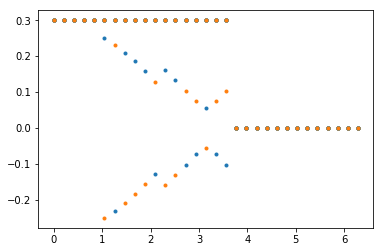

In [11]:
for p in range(len(EJdisp)):
    pp.plot(phiarray,EJdisp[p],'.')
#pp.axis([0,2*np.pi,.95,1.1])

In [32]:
print(GammaL,GammaR,delta,ET)

(0.36, 0.36, 0.3, 2.107444419312218)


In [67]:
list1

[1, 2, 3, -0.5, -2]

[-0.005, 0.005, -1e-10, 1e-10]

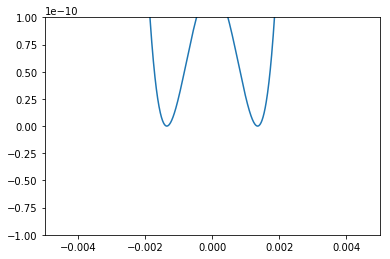

In [305]:
xarray=np.linspace(-0.004,0.004,1000)
yarray=np.array([fdet(xarray[l]) for l in range(len(xarray))])
pp.plot(xarray,yarray)
pp.axis([-0.005,0.005,-0.0000000001,0.0000000001])

In [292]:
mu

1.87

In [133]:
np.sqrt(5)

2.23606797749979